# meeting 5 anaylsis

## objectives:
1. try multiple triggers for now it is 252/63 and 60/20
2. create a table for three of them and compare the results
3. find the corrlation between our gold strategy and market


In [17]:
import pandas as pd 
import quantstats as qs
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
pnl_data_path = '/Users/liubenchen/Desktop/Low-Tide-Capital-Management/data/pnl_data/XAUBNG.csv'
data =  pd.read_csv(pnl_data_path, parse_dates=['Date'])
data.columns

Index(['Date', 'Close', 'pct_change', 'sma252', 'sma63', 'sma20', 'sma60',
       'signal', 'position', 'start_time', 'equity_num', 'cash',
       'equity_value', 'net_value', 'equity_change', 'equity_curve',
       'close_pnl'],
      dtype='object')

In [19]:
mktdata = pd.read_csv('/Users/liubenchen/Desktop/Low-Tide-Capital-Management/data/pnl_data/60_40Ports.csv', parse_dates=['Date'])
mktdata.columns

Index(['Date', 'Bond', 'Stock', 'Bond_pctchange', 'Bond_pnl',
       'Stock_pctchange', 'Stock_pnl', 'ports_pctchange', 'ports_pnl'],
      dtype='object')

In [20]:
data = data.merge(mktdata[['Date', 'ports_pnl', 'ports_pctchange']], on='Date', how='left')
data.columns

Index(['Date', 'Close', 'pct_change', 'sma252', 'sma63', 'sma20', 'sma60',
       'signal', 'position', 'start_time', 'equity_num', 'cash',
       'equity_value', 'net_value', 'equity_change', 'equity_curve',
       'close_pnl', 'ports_pnl', 'ports_pctchange'],
      dtype='object')

## 1. draw the triggers in the chart

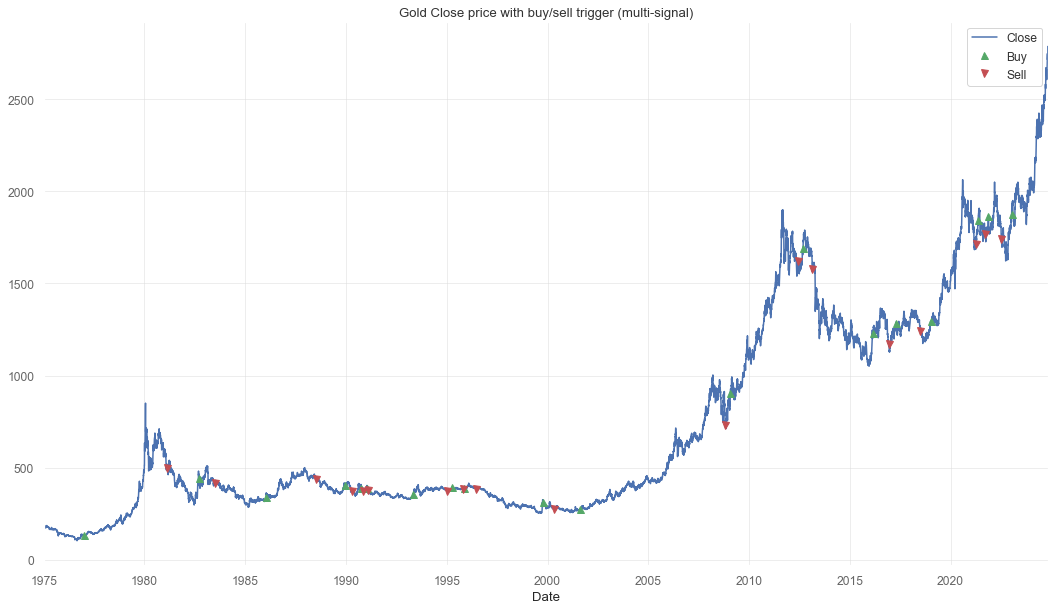

In [21]:
# plot the trigger in the data
data['trigger'] = data['signal'] - data['signal'].shift(1)
# if trigger is 1 then buy, if trigger is -1 then sell
# draw a graph about the Close price and the trigger
# and set the Date as the index
fig, ax = plt.subplots(figsize=(18, 10))
if 'Date' in data.columns:
    data.set_index('Date', inplace=True)
data['Close'].plot(ax=ax)
data['Close'][data['trigger'] == 1].plot(ax=ax, ls='', marker='^', markersize=7, color='g')
data['Close'][data['trigger'] == -1].plot(ax=ax, ls='', marker='v', markersize=7, color='r')
# add some notation
plt.legend(['Close', 'Buy', 'Sell'])
plt.title('Gold Close price with buy/sell trigger (multi-signal)')
plt.show()


In [22]:
def get_metrics(data):
    ret = {'sharp':round(qs.stats.sharpe(data, periods=12), 6),
    'avg_return':100 * round(qs.stats.avg_return(data), 6),
    'max_drawdown':100 * round(qs.stats.max_drawdown(data), 6),
    'win_rate':round(qs.stats.win_rate(data), 6),
    'calmar':round(qs.stats.calmar(data), 6),
    'volatility':round(qs.stats.volatility(data), 6),
    }
    
    annulized_return = data.mean() * 12
    ret['annulized_return'] = round(annulized_return, 6)
    return ret

## 2. static allocation about new ports and find the corr metrix

In [26]:
port_dict = {'6040Ports': data['ports_pctchange'], 'Strategy': data['equity_change']}
for i in [0.05, 0.1, 0.2, 0.3, 0.4]:
    port_dict[f'Mixed Ports {i}'] = data['equity_change'] * i + data['ports_pctchange']
metrics_dict = {}
for key in port_dict.keys():
    # convert to monthly data
    port_dict[key] = port_dict[key].resample('M').apply(lambda x: (x + 1).prod() - 1)
    metrics_dict[key] = get_metrics(port_dict[key])


metrics_df = pd.DataFrame(metrics_dict)
metrics_df

/var/folders/_l/wsff1qyx3yn9ct4rzkczkxfh0000gn/T/ipykernel_6031/35114962.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port_dict[key] = port_dict[key].resample('M').apply(lambda x: (x + 1).prod() - 1)


,6040Ports,Strategy,Mixed Ports 0.05,Mixed Ports 0.1,Mixed Ports 0.2,Mixed Ports 0.3,Mixed Ports 0.4
sharp,0.872301,0.480828,0.893798,0.906615,0.910210,0.893247,0.865455
avg_return,0.604400,0.992500,0.631000,0.657500,0.710400,0.763200,0.815900
max_drawdown,-17.130800,-35.926100,-17.333700,-17.538500,-18.678700,-20.371600,-22.086700
win_rate,0.683924,0.539295,0.683924,0.664850,0.664850,0.673025,0.656676
calmar,0.176374,0.121426,0.182096,0.187564,0.190089,0.186751,0.183410
volatility,0.233466,0.699230,0.237852,0.244339,0.262963,0.287874,0.317631
annulized_return,0.044441,0.073367,0.046391,0.048340,0.052231,0.056113,0.059987


<AxesSubplot:>

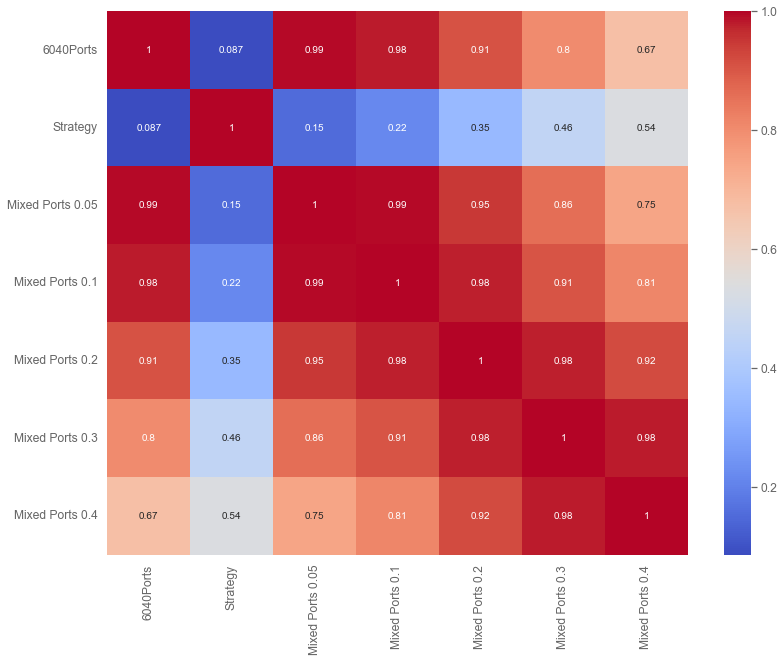

In [25]:
# plot the corrlation matrix
corr = pd.DataFrame(port_dict).corr()
figsize = (13, 10)
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)